# Quantum Differential Machine Learning
## As Applied to Europeans Options Pricing

In [49]:
import pennylane as qml                                             # Pennylane.ai by Xanadu                
from pennylane import numpy as np                                   # Basic Maths 
from scipy import stats as si                                       # Statistical Maths
from matplotlib import pyplot as plt                                # Analysis
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed     # Learning

### Seeds and Constants
We define hyperparameters $C_1$, $C_2$, $\beta$, and $\gamma$ for embedding, as well as the initial market parameters with Strike Price $K$, Maturation period $T$, risk free return rate $r$, and volatility $\sigma$

We also define the function for embedding which embeds $X$ to $x$ via $x = \tanh{(\frac{X}{a})^{b}}$
We also define the reverse map for that process, which returns $X$ from $x$ via $X = a * (\text{artanh }{x})^{\frac{1}{b}}$. We will later, in the QNN, map $x$ into $\varphi$ using $\varphi = \arccos{x}$.

In [2]:
# CONSTS
C_1 = 100 # Values obtained from T. Sakuma, Soka University
C_2 = 10  
β = 5.0   
γ = 0.75  
          
K = 100   
T = 0.25  
r = 0     
σ = 0.15  

# RANDOM SEEDED FOR REPLICABILITY
np.random.seed(42)

# EMBEDDINGS
def hyp_normalise(x, a, b):
    return np.tanh((x/a)**b)

def hyp_unenmbed(x, a, b):
    return np.power(np.arctanh(x), 1/b) * a

### Black-Scholes Solutions
The Black-Scholes Equations have analytical solutions for the boundary conditions defined by European Options.
We have $V = S \Phi(d_1) - Ke^{-rt} \Phi(d_2)$, where $d_1, d_2 = \frac{\ln{\frac{S}{K}} + t(r \pm \frac{1}{2}\sigma^2))}{\sigma\sqrt{t}}$. The Option Delta is given by $\Delta = \Phi(d_1)$

In [3]:
# ANALYTIC BLACK-SCHOLES VALUES
def BS_EuroCall_V(S, K, t, r, σ):
    d1 = (np.log(S/K) + (r + 0.5 * σ**2) * t) / (σ * np.sqrt(t)) # d1 = (ln(S/K) + (r + ½σ²))/(σ√t)
    d2 = (np.log(S/K) + (r - 0.5 * σ**2) * t) / (σ * np.sqrt(t)) # d2 = (ln(S/K) + (r - ½σ²))/(σ√t)

    V = S * si.norm.cdf(d1) - K * np.exp(-r*t) * si.norm.cdf(d2) #  V = SΦ(d1) - exp(-rt)Φ(d2)
    
    return V

def BS_EuroCall_Δ(S, K, t, r, σ):
    d1 = (np.log(S/K) + (r + 0.5 * σ**2) * t) / (σ * np.sqrt(t)) # d1 = (ln(S/K) + (r + ½σ²))/(σ√t)

    Δ = si.norm.cdf(d1)                                          # Δ = Φ(d1)

    return Δ

#### Training and Testing Datasets

In [4]:
# DATA
num_of_data = 10
while (True):
    Spot_training = sorted([np.random.randint(90, 120) for i in range(num_of_data)])
    Spot_testing = sorted([np.random.randint(90, 120) for i in range(num_of_data)])

    range_training = max(Spot_training) - min(Spot_training)
    
    if range_training / 30 > 0.9:
        break


Vals_training = [BS_EuroCall_V(S, K, T, r, σ) for S in Spot_training]
Dels_training = [BS_EuroCall_Δ(S, K, T, r, σ) for S in Spot_training]

Vals_testing = [BS_EuroCall_V(S, K, T, r, σ) for S in Spot_testing]
Dels_testing = [BS_EuroCall_Δ(S, K, T, r, σ) for S in Spot_testing]

X_training = [hyp_normalise(S, C_1, β) for S in Spot_training]
Y_training = [hyp_normalise(V, C_2, γ) for V in Vals_training]

X_testing = [hyp_normalise(S, C_1, β) for S in Spot_testing]
Y_testing = [hyp_normalise(V, C_2, γ) for V in Vals_testing]

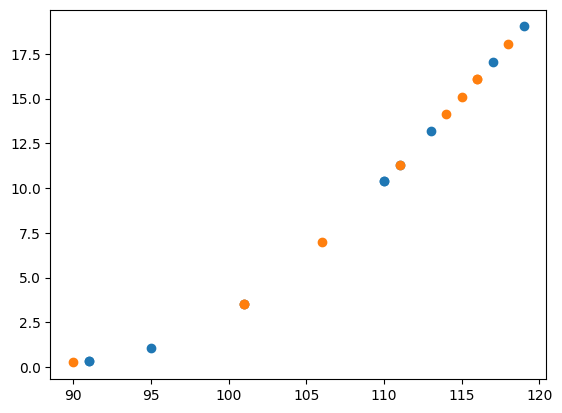

In [5]:
plt.scatter(Spot_training, Vals_training)
plt.scatter(Spot_testing, Vals_testing)

plt.show()

### Quantum Circuit
The two qubit circuit consists of three layers, the gate $U_{in}$ consists of the gates $R_Y(\varphi_1)$ and $R_Y(\varphi_2)$ applied to the first and second qubits respectively, an $R_{XX}(\varphi_3$ to entangle the two layers and a strongly entangling layer, $U_P(\Theta), a second $U_{in}$ consisting of $R_Y(\varphi_4)$ and $R_Y(\varphi_5)$. We measure the value of $\langle 00|U^\dagger ZU|00 \rangle$.

In [6]:
# CIRCUIT
n_layers = 3
n_qubits = 2


def qnn(Θ, x, paramshift = 0): # Quantum Neural Network

    dev = qml.device("default.qubit", wires=n_qubits) 
    # Seperate device for each run since multithreading/multiprocessing intereres

    @qml.qnode(dev, diff_method="parameter-shift")
    def circuit():
        φ = [np.arcsin(x) for i in range(5)]  
        
        φ[np.abs(paramshift) - 1] += np.sign(paramshift) * 0.5 * np.pi 

        qml.RY(φ[0],      wires=0)
        qml.RY(φ[1],      wires=1)
        qml.IsingXX(φ[2], wires=[0,1])
        qml.RY(φ[3],      wires=0)
        qml.RY(φ[4],      wires=1)

        qml.templates.StronglyEntanglingLayers(Θ, wires=range(n_qubits))

        return qml.expval(qml.PauliZ(0))
    
    return circuit()

### Costs & Gradients

In [7]:
# COST FUNC

def square_loss(desired, predictions):
    sqr_loss = 0
    for loss, pred in zip(desired, predictions):
        sqr_loss += (loss - pred)**2 / loss
    sqr_loss = sqr_loss / len(desired)
    return sqr_loss

def cost(dist, inputs, labels):
    preds = [qnn(dist, x) for x in inputs]
    return square_loss(labels, preds)

# GRADIENTS
def grad(circ, dist, x, param): 
    # Market param gradient via paramshift
    # grad = ½(f(x + ½π) - f(x - ½π))
    f_plus = circ(dist, x, param)
    f_minus = circ(dist, x, -param)

    return 0.5 * (f_plus - f_minus)

### Learning

In [52]:
# OPTIMIZER
opt = qml.AdamOptimizer(0.01)

def train(seed, n_L, n_Q, X_training, Y_training, X_testing, Y_testing):

    np.random.seed(seed)
    Θ = [np.random.uniform(high = 2*np.pi, size=(n_L, n_Q, 3))]

    historic_training_cost = []
    historic_testing_cost = []

    for epoch in range(301):
        Θ_new, _cost = opt.step_and_cost(lambda v: cost(v, X_training, Y_training), Θ[epoch])
        _test_cost = cost(Θ[epoch], X_testing, Y_testing)

        Θ.append(Θ_new)

        historic_training_cost.append(_cost)
        historic_testing_cost.append(_test_cost)
    
    return {
        'seed': seed,
        'Θ': Θ,                                                                 # full history of Θ               
        'θ': Θ[np.argmin(historic_testing_cost)],                               # optimal θ
        'historic_training_cost': historic_training_cost,                       # full history of training costs
        'historic_testing_cost': historic_testing_cost,                         # full history of testing costs
        'best_index': np.argmin(historic_testing_cost),                         # index of θ in Θ, dumb ik
        'best_cost': historic_testing_cost[np.argmin(historic_testing_cost)]    # best cost
    }

def parallel_training(N, n_L, n_Q, X_train, Y_train, X_test, Y_test):

    results = []

    with ThreadPoolExecutor(max_workers=4) as executor:     
        futures = [                                         
            executor.submit(                                
                train,                  # process pool throws error
                seed,                   # thread pool cuckblocked by GIL
                n_L,                    # fuck python
                n_Q,
                X_train,
                Y_train,
                X_test,
                Y_test,
            ) 
            
            for seed in range(N)

        ]

        for future in as_completed(futures):
            results.append(future.result())

    return results

In [53]:
networks = parallel_training(4, n_layers, n_qubits, X_training, Y_training, X_testing, Y_testing)
networks

[{'seed': 1,
  'Θ': [tensor([[[2.62022653e+00, 4.52593227e+00, 7.18638172e-04],
            [1.89961158e+00, 9.22094457e-01, 5.80180502e-01]],
   
           [[1.17030742e+00, 2.17122208e+00, 2.49296356e+00],
            [3.38548539e+00, 2.63387681e+00, 4.30536110e+00]],
   
           [[1.28461137e+00, 5.51737457e+00, 1.72081323e-01],
            [4.21267161e+00, 2.62200340e+00, 3.51035172e+00]]], requires_grad=True),
   tensor([[[ 2.61022654,  4.53593227, -0.00928136],
            [ 1.88961158,  0.91209446,  0.5701805 ]],
   
           [[ 1.16030742,  2.18122208,  2.50296356],
            [ 3.39548538,  2.64387681,  4.3053611 ]],
   
           [[ 1.28461137,  5.51737457,  0.17208132],
            [ 4.20267161,  2.6120034 ,  3.51035172]]], requires_grad=True),
   tensor([[[ 2.6070825 ,  4.53667103, -0.01038565],
            [ 1.88132928,  0.90364728,  0.57068213]],
   
           [[ 1.16080905,  2.1758974 ,  2.50873272],
            [ 3.39384066,  2.64482005,  4.3053611 ]],
   
    

In [46]:
historic_testing_cost = [network['historic_testing_cost'] for network in networks]
historic_training_cost = [network['historic_training_cost'] for network in networks]
θ = [network['θ'] for network in networks]
best_costs = [network['best_cost'] for network in networks]
θ_opt = θ[np.argmin(best_costs)]

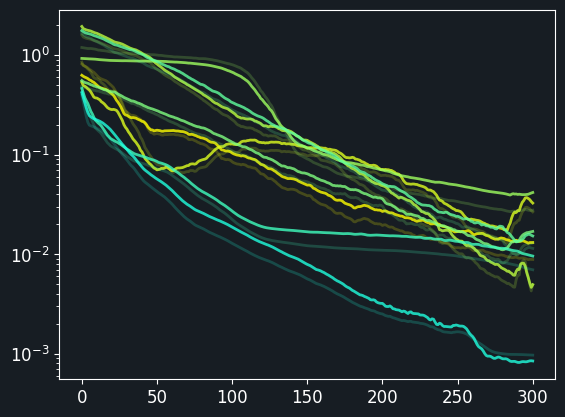

In [47]:
for i in range(len(historic_testing_cost)):
    plt.plot(list(range(len(historic_testing_cost[i]))), historic_testing_cost[i], label="Testing " + str(i), color=(1 - (i/8), 1, (i/8)), alpha=0.8)
    plt.plot(list(range(len(historic_testing_cost[i]))), historic_training_cost[i], label="Training " + str(i), color=(1 - (i/8), 1, (i/8)), alpha=0.2)

#plt.axvline(np.argmin(historic_testing_cost), ls=":")

# plt.legend()
plt.yscale("log")
#plt.xlabel("Epoch")
#plt.ylabel("Cost")

# Define the "city_lights" theme
#plt.style.use('dark_background')  # Base dark background
plt.gcf().patch.set_facecolor('#171d23')
plt.gca().patch.set_facecolor('#171d23')
plt.show()



c:\Users\arham\AppData\Local\Programs\Python\Python311\Lib\site-packages\pennylane\numpy\tensor.py:155: RuntimeWarning: invalid value encountered in power
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


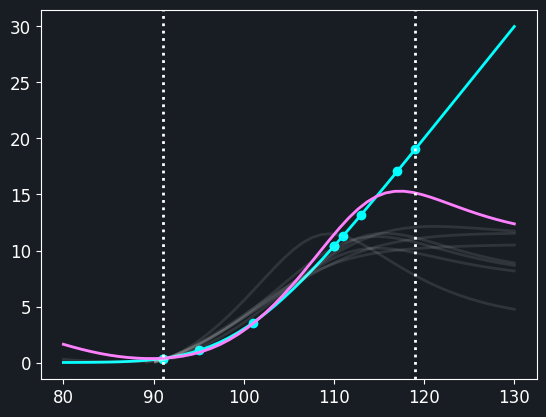

In [44]:
lin_Spots = np.linspace(80, 130, 50)
lin_Vals_BS = [BS_EuroCall_V(s, K, T, r, σ) for s in lin_Spots]
plt.plot(lin_Spots, lin_Vals_BS, label="Black-Scholes Value", color="cyan")

for i in range(len(θ)):
    lin_Vals_pred = [hyp_unenmbed(y, C_2, γ) for y in [qnn(θ[i], x) for x in [hyp_normalise(S, C_1, β) for S in lin_Spots]]]
    plt.plot(lin_Spots, lin_Vals_pred, label="Learnt QDML Value " + str(i), color=(1, 1, 1), alpha=0.1)

plt.plot(lin_Spots, [hyp_unenmbed(y, C_2, γ) for y in [qnn(θ_opt, x) for x in [hyp_normalise(S, C_1, β) for S in lin_Spots]]], color=(1, 0.5, 1))

plt.scatter(Spot_training, Vals_training, color="cyan")

plt.axvline(min(Spot_training), ls=":")
plt.axvline(max(Spot_training), ls=":")

plt.gcf().patch.set_facecolor('#171d23')
plt.gca().patch.set_facecolor('#171d23')

#plt.legend()
#plt.xlabel("Spot Prices")
#plt.ylabel("Values")

plt.show()

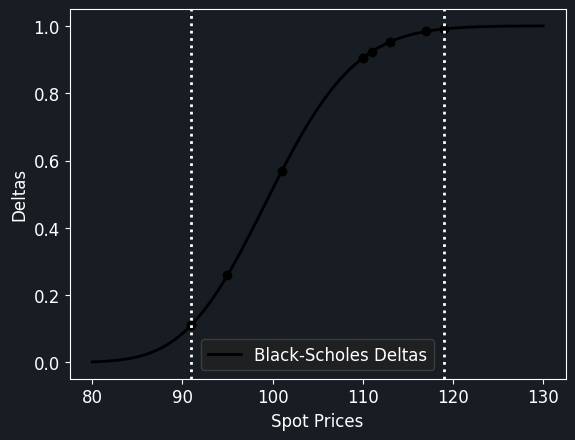

In [54]:
lin_Spots = np.linspace(80, 130, 50)
lin_Dels_BS = [BS_EuroCall_Δ(s, K, T, r, σ) for s in lin_Spots]
plt.plot(lin_Spots, lin_Dels_BS, label="Black-Scholes Deltas", color="black")

# for i in range(len(θ)):
#     lin_Vals_pred = [hyp_unenmbed(y, C_2, γ) for y in [qnn(θ[i], x) for x in [hyp_normalise(S, C_1, β) for S in lin_Spots]]]
#     plt.plot(lin_Spots, lin_Vals_pred, label="Learnt QDML Value " + str(i), color=((1-(i/8)), 0, (i/8)), alpha=0.5)

plt.scatter(Spot_training, Dels_training, color="black")

plt.axvline(min(Spot_training), ls=":")
plt.axvline(max(Spot_training), ls=":")

plt.gcf().patch.set_facecolor('#171d23')
plt.gca().patch.set_facecolor('#171d23')

plt.legend()
plt.xlabel("Spot Prices")
plt.ylabel("Deltas")

plt.show()